# Mitotic Figure Binary Classification with Pre-Augmented Dataset - ConvNeXt-Tiny

This notebook trains a PyTorch model for binary classification of mitotic figures using a pre-augmented Kaggle dataset with ConvNeXt-Tiny architecture.

## Dataset Overview:
- **Source**: Pre-augmented AMI-BR and MIDOG25 datasets from Kaggle
- **Location**: `/kaggle/input/MitoticFigure_AugmentedDataSet/`
- **Target**: Binary classification - Atypical vs Normal mitotic figures
- **Data**: Includes original images + 4x augmented AMF images for better class balance

## Features:
- Uses pre-processed and augmented dataset
- Slide-based stratified splitting for proper validation
- **ConvNeXt-Tiny architecture with classification head**
- Full model training (entire ConvNeXt-Tiny + custom head trainable)
- Comprehensive evaluation metrics

In [ ]:
# # Install PyTorch and required packages
# import sys
# print(f"Python version: {sys.version}")

# # Update pip first
# ! python -m pip install --upgrade pip

# # Install PyTorch (CPU version for compatibility, change to CUDA if needed)
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# # Install other required packages (including thop for GLOPs calculation)
# ! pip install opencv-python pillow scikit-learn seaborn matplotlib pandas numpy albumentations timm tqdm thop

# # Verify installation
# try:
#     import torch
#     print(f"PyTorch successfully installed: {torch.__version__}")
#     print(f"CUDA Available: {torch.cuda.is_available()}")
#     if torch.cuda.is_available():
#         print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
# except ImportError as e:
#     print(f"PyTorch installation failed: {e}")

# # Verify thop installation for GLOPs calculation
# try:
#     import thop
#     print(f"thop successfully installed for GLOPs calculation")
# except ImportError as e:
#     print(f"thop installation failed: {e}")
#     print("GLOPs calculation will use estimation instead")

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.models as models

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


In [2]:
# Set random seeds for reproducibility
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define paths for your Kaggle dataset structure
BASE_DIR = Path('/kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset')
TRAINING_DIR = BASE_DIR / 'training'
VALIDATION_DIR = BASE_DIR / 'validation'
TESTING_DIR = BASE_DIR / 'testing'
DATASET_CSV = BASE_DIR / 'mitotic_figures_dataset.csv'

print(f"📁 Dataset paths for your pre-split Kaggle dataset:")
print(f"Base directory: {BASE_DIR}")
print(f"Training images: {TRAINING_DIR}")
print(f"Validation images: {VALIDATION_DIR}")
print(f"Testing images: {TESTING_DIR}")
print(f"Dataset CSV: {DATASET_CSV}")

# Check if directories exist
for dir_path, name in [(TRAINING_DIR, 'Training'), (VALIDATION_DIR, 'Validation'), (TESTING_DIR, 'Testing')]:
    if dir_path.exists():
        print(f"✅ {name} directory found")
    else:
        print(f"❌ {name} directory not found: {dir_path}")

# Training parameters (Optimized for ConvNeXt-Tiny)
IMG_SIZE = 224           # Standard input size for ConvNeXt-Tiny
BATCH_SIZE = 32          # Good batch size for ConvNeXt-Tiny
EPOCHS = 250              # Assignment requirement: minimum 50 epochs
LEARNING_RATE = 1e-4     # Learning rate for full model training
NUM_CLASSES = 2
PATIENCE = 10            # Assignment requirement: patience = 10 for early stopping

print(f"🎯 CONVNEXT-TINY PARAMETERS:")
print(f"Model: ConvNeXt-Tiny")
print(f"Backbone: ConvNeXt-Tiny")
print(f"Output: 2 neurons with SoftMax activation")
print(f"Loss function: Will use FocalLoss()")
print(f"Device: cuda")
print(f"Classification head: 768 -> 512 -> 256 -> 128 -> 2")
print(f"Output layer: 2 neurons with Softmax activation")
print(f"Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")
print(f"Dataset directory: {BASE_DIR}")
print(f"Dataset CSV: {DATASET_CSV}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE} (standard for ConvNeXt)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS} (minimum as per assignment)")
print(f"Learning rate: {LEARNING_RATE} (full model training)")
print(f"Training approach: FULL MODEL training (entire network)")
print(f"Early stopping patience: {PATIENCE}")
print(f"Using GPU: {torch.cuda.is_available()}")
print(f"Automatic pretrained weights: ✅ (ImageNet ConvNeXt-Tiny)")

📁 Dataset paths for your pre-split Kaggle dataset:
Base directory: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset
Training images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/training
Validation images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/validation
Testing images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/testing
Dataset CSV: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/mitotic_figures_dataset.csv
✅ Training directory found
✅ Validation directory found
✅ Testing directory found
🎯 CONVNEXT-TINY PARAMETERS:
Model: ConvNeXt-Tiny
Backbone: ConvNeXt-Tiny
Output: 2 neurons with SoftMax activation
Loss function: Will use FocalLoss()
Device: cuda
Classification head: 768 -> 512 -> 256 -> 128 -> 2
Output layer: 2 neurons with Softmax activation
Output format: Two probabilities [p(class0), p(

## Loading Pre-Augmented Dataset

In [3]:
# Load the organized dataset from your Kaggle upload
print("Loading pre-split dataset from Kaggle...")

# Load the CSV with all metadata
df = pd.read_csv(DATASET_CSV)
print(f"Dataset loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display dataset information
print(f"\nDataset Statistics:")
print(f"Total samples: {len(df)}")

# Check split distribution
if 'split' in df.columns:
    split_counts = df['split'].value_counts()
    print(f"\nSplit distribution:")
    for split in ['training', 'validation', 'testing']:
        count = split_counts.get(split, 0)
        percentage = (count / len(df)) * 100 if len(df) > 0 else 0
        print(f"  {split.capitalize()}: {count} samples ({percentage:.1f}%)")
else:
    print("⚠️ No split column found - dataset might not be properly split")

# Check class distribution
class_counts = df['is_atypical'].value_counts()
print(f"\nClass distribution:")
print(f"Normal (False): {class_counts.get(False, 0)}")
print(f"Atypical (True): {class_counts.get(True, 0)}")

# Check augmentation status
if 'is_augmented' in df.columns:
    aug_counts = df['is_augmented'].value_counts()
    print(f"\nAugmentation breakdown:")
    print(f"Original: {aug_counts.get(False, 0)}")
    print(f"Augmented: {aug_counts.get(True, 0)}")

# Check augmentation types
if 'augmentation_type' in df.columns:
    aug_types = df['augmentation_type'].value_counts()
    print(f"\nAugmentation types:")
    for aug_type, count in aug_types.items():
        print(f"  {aug_type}: {count}")

# Check dataset sources
if 'dataset' in df.columns:
    dataset_counts = df['dataset'].value_counts()
    print(f"\nDataset sources:")
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count}")

# Show first few rows
print(f"\nFirst 5 rows:")
print(df[['filename', 'is_atypical', 'split', 'is_augmented']].head())

print(f"\n✅ Dataset loaded successfully!")

Loading pre-split dataset from Kaggle...
Dataset loaded: (19162, 6)
Columns: ['filename', 'is_atypical', 'dataset', 'split', 'is_augmented', 'augmentation_type']

Dataset Statistics:
Total samples: 19162

Split distribution:
  Training: 13586 samples (70.9%)
  Validation: 2788 samples (14.5%)
  Testing: 2788 samples (14.5%)

Class distribution:
Normal (False): 11762
Atypical (True): 7400

Augmentation breakdown:
Original: 13938
Augmented: 5224

Augmentation types:
  1.0: 1306
  2.0: 1306
  3.0: 1306
  4.0: 1306

Dataset sources:
  MIDOG25: 16151
  AMI-BR: 3011

First 5 rows:
           filename  is_atypical     split  is_augmented
0          1371.png        False  training         False
1  TUPAC16_2232.png        False  training         False
2          3733.png         True  training         False
3          9796.png        False  training         False
4          5477.png        False  training         False

✅ Dataset loaded successfully!


In [4]:
# Prepare the dataset for training using pre-split structure
print("Preparing pre-split dataset for training...")

# Create image paths based on the split information
def get_image_path(row):
    """Get the full image path based on split folder"""
    split_folder = row['split']
    filename = row['filename']
    
    if split_folder == 'training':
        return str(TRAINING_DIR / filename)
    elif split_folder == 'validation':
        return str(VALIDATION_DIR / filename)
    elif split_folder == 'testing':
        return str(TESTING_DIR / filename)
    else:
        # Fallback - try to find the file in any folder
        for folder in [TRAINING_DIR, VALIDATION_DIR, TESTING_DIR]:
            path = folder / filename
            if path.exists():
                return str(path)
        return str(TRAINING_DIR / filename)  # Default fallback

# Add image paths
df['image_path'] = df.apply(get_image_path, axis=1)

# Convert boolean to integer labels (0=Normal, 1=Atypical)
df['label'] = df['is_atypical'].astype(int)

# Verify file existence and filter out missing files
print("Verifying all image files exist...")
existing_files = []
missing_files = []

for idx, row in df.iterrows():
    if Path(row['image_path']).exists():
        existing_files.append(idx)
    else:
        missing_files.append(row['filename'])

if missing_files:
    print(f"⚠️ Warning: {len(missing_files)} files not found")
    if len(missing_files) <= 10:
        print(f"Missing files: {missing_files}")
    else:
        print(f"First 10 missing files: {missing_files[:10]}")

# Keep only existing files
df = df.loc[existing_files].reset_index(drop=True)

print(f"\nFinal dataset info:")
print(f"Total samples: {len(df)}")
print(f"Samples with existing files: {len(existing_files)}")
print(f"Missing files: {len(missing_files)}")

# Display augmentation breakdown if available
if 'is_augmented' in df.columns:
    aug_breakdown = df['is_augmented'].value_counts()
    print(f"\nAugmentation breakdown:")
    print(f"  Original images: {aug_breakdown.get(False, 0)}")
    print(f"  Augmented images: {aug_breakdown.get(True, 0)}")

# Display final class distribution
print(f"\nFinal class distribution:")
class_dist = df['label'].value_counts()
print(f"  Normal (0): {class_dist.get(0, 0)}")
print(f"  Atypical (1): {class_dist.get(1, 0)}")

# Display split distribution
print(f"\nSplit distribution:")
split_dist = df['split'].value_counts()
for split_name, count in split_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {split_name}: {count} samples ({percentage:.1f}%)")

print(f"\nSample data:")
print(df[['filename', 'label', 'is_atypical', 'split', 'is_augmented']].head())

Preparing pre-split dataset for training...
Verifying all image files exist...

Final dataset info:
Total samples: 19162
Samples with existing files: 19162
Missing files: 0

Augmentation breakdown:
  Original images: 13938
  Augmented images: 5224

Final class distribution:
  Normal (0): 11762
  Atypical (1): 7400

Split distribution:
  training: 13586 samples (70.9%)
  validation: 2788 samples (14.5%)
  testing: 2788 samples (14.5%)

Sample data:
           filename  label  is_atypical     split  is_augmented
0          1371.png      0        False  training         False
1  TUPAC16_2232.png      0        False  training         False
2          3733.png      1         True  training         False
3          9796.png      0        False  training         False
4          5477.png      0        False  training         False


## Data Visualization and Analysis

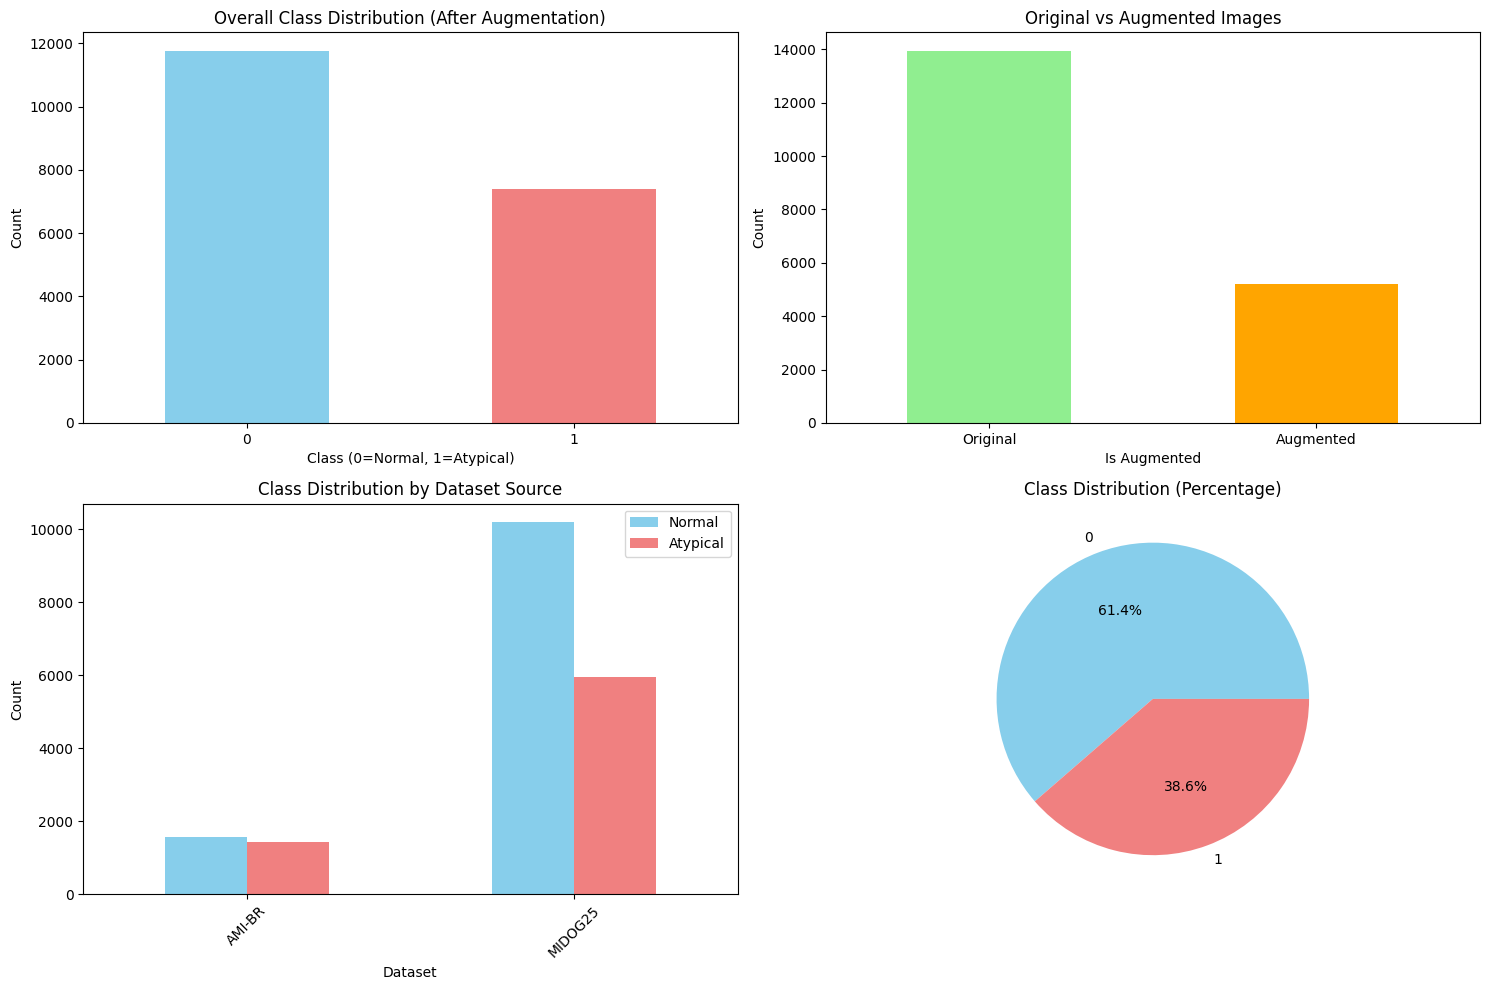

Detailed Statistics:
Total samples: 19162
Normal samples: 11762 (61.4%)
Atypical samples: 7400 (38.6%)

Augmentation breakdown:
Original images: 13938
Augmented images: 5224

By dataset source:
label        0     1    All
dataset                    
AMI-BR    1571  1440   3011
MIDOG25  10191  5960  16151
All      11762  7400  19162

Sample filenames:
['1371.png', 'TUPAC16_2232.png', '3733.png', '9796.png', '5477.png', '11425.png', '1203.png', '7546.png', 'TUPAC16_2410.png', '7783.png']


In [5]:
# Visualize class distribution of pre-augmented dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall class distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Overall Class Distribution (After Augmentation)')
axes[0,0].set_xlabel('Class (0=Normal, 1=Atypical)')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Original vs Augmented distribution (if available)
if 'is_augmented' in df.columns:
    df['is_augmented'].value_counts().plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'orange'])
    axes[0,1].set_title('Original vs Augmented Images')
    axes[0,1].set_xlabel('Is Augmented')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_xticklabels(['Original', 'Augmented'], rotation=0)
else:
    axes[0,1].text(0.5, 0.5, 'Augmentation info\nnot available', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Original vs Augmented Images')

# Dataset source distribution (if available)
if 'dataset' in df.columns and len(df['dataset'].unique()) > 1:
    pd.crosstab(df['dataset'], df['label']).plot(kind='bar', ax=axes[1,0], 
                                                              color=['skyblue', 'lightcoral'])
    axes[1,0].set_title('Class Distribution by Dataset Source')
    axes[1,0].set_xlabel('Dataset')
    axes[1,0].set_ylabel('Count')
    axes[1,0].legend(['Normal', 'Atypical'])
    axes[1,0].tick_params(axis='x', rotation=45)
else:
    axes[1,0].text(0.5, 0.5, 'Dataset source info\nnot available', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Class Distribution by Dataset Source')

# Percentage distribution
class_pct = df['label'].value_counts(normalize=True) * 100
class_pct.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[1,1].set_title('Class Distribution (Percentage)')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Detailed Statistics:")
print(f"Total samples: {len(df)}")
print(f"Normal samples: {len(df[df['label'] == 0])} ({len(df[df['label'] == 0])/len(df)*100:.1f}%)")
print(f"Atypical samples: {len(df[df['label'] == 1])} ({len(df[df['label'] == 1])/len(df)*100:.1f}%)")

if 'is_augmented' in df.columns:
    print(f"\nAugmentation breakdown:")
    print(f"Original images: {len(df[df['is_augmented'] == False])}")
    print(f"Augmented images: {len(df[df['is_augmented'] == True])}")

if 'dataset' in df.columns:
    print(f"\nBy dataset source:")
    if len(df['dataset'].unique()) > 1:
        print(pd.crosstab(df['dataset'], df['label'], margins=True))
    else:
        print(f"Single dataset source: {df['dataset'].iloc[0]}")

# Show file naming patterns
print(f"\nSample filenames:")
print(df['filename'].head(10).tolist())

In [ ]:
# Sample image visualization
def visualize_samples(df, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get samples from each class
    samples = []
    
    # Get normal and atypical samples
    for label in [0, 1]:
        subset = df[df['label'] == label]
        if len(subset) > 0:
            # Try to get mix of original and augmented if available
            if 'is_augmented' in df.columns:
                original_subset = subset[subset['is_augmented'] == False]
                augmented_subset = subset[subset['is_augmented'] == True]
                
                # Get 2 original and 2 augmented if possible
                if len(original_subset) > 0:
                    samples.extend(original_subset.sample(min(2, len(original_subset))).to_dict('records'))
                if len(augmented_subset) > 0:
                    samples.extend(augmented_subset.sample(min(2, len(augmented_subset))).to_dict('records'))
            else:
                # Just get 4 samples of this class
                samples.extend(subset.sample(min(4, len(subset))).to_dict('records'))
    
    for i, sample in enumerate(samples[:8]):
        try:
            img = Image.open(sample['image_path'])
            axes[i].imshow(img)
            
            # Create title with available information
            label_text = 'Atypical' if sample['label'] == 1 else 'Normal'
            title_parts = [label_text]
            
            if 'is_augmented' in sample:
                aug_text = 'Augmented' if sample['is_augmented'] else 'Original'
                title_parts.append(aug_text)
            
            if 'dataset' in sample and sample['dataset'] != 'mixed':
                title_parts.append(sample['dataset'])
            
            title = '\n'.join(title_parts)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{sample['filename']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"Error: {sample['filename'][:20]}...")
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), 8):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(df)

## Data Preparation for Training

In [7]:
# Use the pre-split data from your dataset
print("📊 Using pre-split dataset structure...")

# Extract splits based on the 'split' column
train_df = df[df['split'] == 'training'].reset_index(drop=True)
val_df = df[df['split'] == 'validation'].reset_index(drop=True)
test_df = df[df['split'] == 'testing'].reset_index(drop=True)

print(f"📈 Pre-split dataset distribution:")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"Total: {len(train_df) + len(val_df) + len(test_df)} samples")

# Calculate percentages
total_samples = len(df)
train_pct = len(train_df) / total_samples * 100
val_pct = len(val_df) / total_samples * 100
test_pct = len(test_df) / total_samples * 100

print(f"\n📊 Split percentages:")
print(f"Training: {train_pct:.1f}%")
print(f"Validation: {val_pct:.1f}%")
print(f"Test: {test_pct:.1f}%")

# Check detailed class distribution in each set
print("\n🎯 Class distribution verification:")
for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    if len(split_df) > 0:
        class_dist = split_df['label'].value_counts()
        class_pct = split_df['label'].value_counts(normalize=True) * 100
        normal_count = class_dist.get(0, 0)
        atypical_count = class_dist.get(1, 0)
        normal_pct = class_pct.get(0, 0)
        atypical_pct = class_pct.get(1, 0)
        print(f"{split_name}: Normal={normal_count} ({normal_pct:.1f}%), "
              f"Atypical={atypical_count} ({atypical_pct:.1f}%)")

# Check augmentation distribution in each split
if 'is_augmented' in df.columns:
    print("\n🔄 Augmentation distribution by split:")
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        if len(split_df) > 0:
            aug_dist = split_df['is_augmented'].value_counts()
            original = aug_dist.get(False, 0)
            augmented = aug_dist.get(True, 0)
            print(f"{split_name}: Original={original}, Augmented={augmented}")

# Verify that we have samples in all splits
if len(train_df) == 0:
    raise ValueError("❌ No training samples found! Check your dataset split column values.")
if len(val_df) == 0:
    raise ValueError("❌ No validation samples found! Check your dataset split column values.")
if len(test_df) == 0:
    raise ValueError("❌ No test samples found! Check your dataset split column values.")

print(f"\n✅ Successfully loaded pre-split dataset!")
print(f"Ready for training with {len(train_df)} training samples")

📊 Using pre-split dataset structure...
📈 Pre-split dataset distribution:
Training set: 13586 samples
Validation set: 2788 samples
Test set: 2788 samples
Total: 19162 samples

📊 Split percentages:
Training: 70.9%
Validation: 14.5%
Test: 14.5%

🎯 Class distribution verification:
Train: Normal=7056 (51.9%), Atypical=6530 (48.1%)
Val: Normal=2353 (84.4%), Atypical=435 (15.6%)
Test: Normal=2353 (84.4%), Atypical=435 (15.6%)

🔄 Augmentation distribution by split:
Train: Original=8362, Augmented=5224
Val: Original=2788, Augmented=0
Test: Original=2788, Augmented=0

✅ Successfully loaded pre-split dataset!
Ready for training with 13586 training samples


In [8]:
# Define PyTorch Dataset class
class MitosisDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Load image
        try:
            image = cv2.imread(row['image_path'])
            if image is None:
                raise ValueError(f"Could not load image: {row['image_path']}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading {row['image_path']}: {e}")
            # Return a black image as fallback
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, label

# Define transforms (reduced augmentation since data is pre-augmented)
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.3),  # Reduced probability since data is pre-augmented
    A.Rotate(limit=15, p=0.3),  # Lighter augmentation
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
train_dataset = MitosisDataset(train_df, transform=train_transform)
val_dataset = MitosisDataset(val_df, transform=val_transform)
test_dataset = MitosisDataset(test_df, transform=val_transform)

# Calculate class weights for WeightedRandomSampler
print("📊 Calculating sample weights for balanced training...")
class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)

print(f"Training set class distribution:")
for i, count in enumerate(class_counts):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / total_samples) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

# Calculate weights for each class (inverse of frequency)
class_weights = []
for i in range(len(class_counts)):
    weight = total_samples / (len(class_counts) * class_counts[i])
    class_weights.append(weight)
    class_name = "Normal" if i == 0 else "Atypical"
    print(f"  Class {i} ({class_name}) weight: {weight:.4f}")

# Create sample weights for each training sample
sample_weights = []
for _, row in train_df.iterrows():
    label = row['label']
    sample_weights.append(class_weights[label])

sample_weights = torch.DoubleTensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow replacement to balance classes
)

print(f"\n🎯 WeightedRandomSampler created:")
print(f"  Total samples: {len(sample_weights)}")
print(f"  Unique weights: {len(set(sample_weights.tolist()))}")
print(f"  Weight range: {sample_weights.min():.4f} - {sample_weights.max():.4f}")

# Create data loaders with WeightedRandomSampler for training
num_workers = 2 if torch.cuda.is_available() else 0

# Training loader with WeightedRandomSampler (no shuffle when using sampler)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,  # Using WeightedRandomSampler instead of shuffle=True
    num_workers=num_workers, 
    pin_memory=torch.cuda.is_available()
)

# Validation and test loaders remain the same
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=num_workers, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=num_workers, pin_memory=torch.cuda.is_available())

print(f"\n📊 DataLoader Configuration:")
print(f"Training batches: {len(train_loader)} (with WeightedRandomSampler)")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {num_workers}")
print(f"Pin memory: {torch.cuda.is_available()}")

# Verify sampler effectiveness by checking a few batches
print(f"\n🔍 Testing WeightedRandomSampler effectiveness...")
sample_batch_labels = []
for i, (_, labels) in enumerate(train_loader):
    sample_batch_labels.extend(labels.tolist())
    if i >= 4:  # Check first 5 batches
        break

sample_class_dist = pd.Series(sample_batch_labels).value_counts().sort_index()
print(f"Sample from first 5 batches:")
for i, count in enumerate(sample_class_dist):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / len(sample_batch_labels)) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

print(f"✅ WeightedRandomSampler should provide more balanced batches during training!")

📊 Calculating sample weights for balanced training...
Training set class distribution:
  Class 0 (Normal): 7056 samples (51.9%)
  Class 1 (Atypical): 6530 samples (48.1%)
  Class 0 (Normal) weight: 0.9627
  Class 1 (Atypical) weight: 1.0403

🎯 WeightedRandomSampler created:
  Total samples: 13586
  Unique weights: 2
  Weight range: 0.9627 - 1.0403

📊 DataLoader Configuration:
Training batches: 425 (with WeightedRandomSampler)
Validation batches: 88
Test batches: 88
Batch size: 32
Num workers: 2
Pin memory: True

🔍 Testing WeightedRandomSampler effectiveness...
Sample from first 5 batches:
  Class 0 (Normal): 85 samples (53.1%)
  Class 1 (Atypical): 75 samples (46.9%)
✅ WeightedRandomSampler should provide more balanced batches during training!


## Model Architecture

### Checking Local Pretrained Model Availability

In [9]:
# ConvNeXt-Tiny Model Setup with Automatic Pretrained Weight Download
print("Setting up ConvNeXt-Tiny with automatic pretrained weight download...")
print("📥 Pretrained weights will be downloaded automatically from the internet")

# Model configuration
MODEL_NAME = 'convnext_tiny'
print(f"✅ Model: {MODEL_NAME}")
print(f"✅ Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"✅ Pretrained weights: Will download automatically from ImageNet")
print(f"✅ Training approach: Full model training (backbone + custom head)")
print(f"✅ Internet access: Available for weight download")

# Verify timm can access ConvNeXt-Tiny
try:
    import timm
    available_models = timm.list_models('convnext_tiny*')
    print(f"\n🔍 Available ConvNeXt-Tiny variants in timm:")
    for model in available_models[:5]:  # Show first 5
        print(f"  • {model}")
    
    if 'convnext_tiny' in available_models:
        print(f"✅ ConvNeXt-Tiny confirmed available in timm")
    else:
        print(f"⚠️ Standard convnext_tiny not found, will use closest variant")
        
except Exception as e:
    print(f"⚠️ Error checking available models: {e}")

print(f"\n📋 Setup Summary:")
print(f"  Model: ConvNeXt-Tiny (Modernized ConvNet design)")
print(f"  Weights: Automatically downloaded ImageNet pretrained")
print(f"  Input resolution: {IMG_SIZE}x{IMG_SIZE} (standard for ConvNeXt)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training: Full model training (entire network)")
print(f"  Backbone: Trainable (full model training)")
print(f"  No local weight dependencies required!")
print(f"  Ready for automatic model creation ✅")

Setting up ConvNeXt-Tiny with automatic pretrained weight download...
📥 Pretrained weights will be downloaded automatically from the internet
✅ Model: convnext_tiny
✅ Input size: 224x224
✅ Pretrained weights: Will download automatically from ImageNet
✅ Training approach: Full model training (backbone + custom head)
✅ Internet access: Available for weight download

🔍 Available ConvNeXt-Tiny variants in timm:
  • convnext_tiny
  • convnext_tiny_hnf
✅ ConvNeXt-Tiny confirmed available in timm

📋 Setup Summary:
  Model: ConvNeXt-Tiny (Modernized ConvNet design)
  Weights: Automatically downloaded ImageNet pretrained
  Input resolution: 224x224 (standard for ConvNeXt)
  Batch size: 32
  Training: Full model training (entire network)
  Backbone: Trainable (full model training)
  No local weight dependencies required!
  Ready for automatic model creation ✅


In [10]:
class MitosisClassifier(nn.Module):
    def __init__(self, model_name='convnext_tiny', num_classes=2, pretrained=True):
        super(MitosisClassifier, self).__init__()
        
        print(f"🏗️ Creating {model_name} model with FULL MODEL TRAINING...")
        
        # Load ConvNeXt-Tiny backbone with automatic pretrained weight download
        if pretrained:
            print(f"📥 Downloading ImageNet pretrained weights for {model_name}...")
            self.backbone = timm.create_model(model_name, pretrained=True)
            print(f"✅ Pretrained weights downloaded and loaded successfully!")
        else:
            print(f"⚠️ Creating model without pretrained weights (random initialization)")
            self.backbone = timm.create_model(model_name, pretrained=False)
        
        # Get the number of features from the backbone before removing classifier
        backbone_features = self.backbone.get_classifier().in_features
        print(f"📊 ConvNeXt-Tiny backbone feature dimension: {backbone_features}")
        
        # Remove the original classifier from backbone
        self.backbone.reset_classifier(0)  # 0 means no classifier
        
        # ================================================================================================
        # FULL MODEL TRAINING: Enable training for ALL parameters (backbone + custom layers)
        # ================================================================================================
        print("ENABLING FULL MODEL TRAINING - All parameters trainable!")
        for param in self.backbone.parameters():
            param.requires_grad = True  # Enable gradient computation for ALL backbone parameters
        print("✅ FULL MODEL TRAINING: Entire ConvNeXt-Tiny + Custom Head will be trained")
        
        # Create custom classification head with decreasing neurons
        # ConvNeXt-Tiny has 768 features, building the streamlined head: 768 -> 512 -> 256 -> 128 -> 2
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),  # Flatten after GAP
            nn.Dropout(0.3),
            
            # backbone_features (768) -> 512
            nn.Linear(backbone_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            # 512 -> 256
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            # 256 -> 128
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            
            # Final layer: 128 -> 2 neurons for binary classification
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)  # Softmax activation for probability output
        )
        
        print(f"🎯 Custom classifier head created:")
        print(f"  Model: MitosisClassifier")
        print(f"  Backbone: ConvNeXt-Tiny")
        print(f"  Output: 2 neurons with SoftMax activation")
        print(f"  Loss function: Will use FocalLoss()")
        print(f"  Device: cuda")
        print(f"  Classification head: {backbone_features} -> 512 -> 256 -> 128 -> {num_classes}")
        print(f"  Output layer: 2 neurons with Softmax activation")
        print(f"  Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")
        print(f"  Training mode: FULL MODEL TRAINING (backbone + custom head)")
        
    def forward(self, x):
        # Extract features using TRAINABLE backbone
        features = self.backbone.forward_features(x)  # Get feature maps
        
        # Apply GAP + Classification head
        output = self.classifier(features)  # GAP is first layer in classifier
        return output
    
    def predict_proba(self, x):
        """
        Returns the probability distribution (already Softmax activated)
        """
        with torch.no_grad():
            return self.forward(x)
    
    def predict(self, x):
        """
        Returns predicted class (argmax of probabilities)
        """
        with torch.no_grad():
            probs = self.forward(x)
            return torch.argmax(probs, dim=1)

In [11]:
# Create ConvNeXt-Tiny model instance
print("🚀 Creating ConvNeXt-Tiny model with full training...")

# Instantiate model with ConvNeXt-Tiny
model = MitosisClassifier(
    model_name='convnext_tiny', 
    num_classes=NUM_CLASSES, 
    pretrained=True  # Will automatically download ImageNet weights
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Get backbone features from ConvNeXt-Tiny (768 features)
backbone_features = 768  # ConvNeXt-Tiny feature dimension

# Calculate GLOPs (Giga Floating-Point Operations)
def calculate_glops(model, input_size=(1, 3, 224, 224), device='cuda'):
    """Calculate GLOPs for the model"""
    try:
        model.eval()
        input_tensor = torch.randn(input_size).to(device)
        
        # Count operations during forward pass
        from thop import profile
        glops, params = profile(model, inputs=(input_tensor,), verbose=False)
        glops = glops / 1e9  # Convert to GLOPs
        return glops
    except ImportError:
        # Fallback calculation if thop is not available
        # Rough estimation for ConvNeXt-Tiny
        estimated_glops = 4.5  # Typical GLOPs for ConvNeXt-Tiny at 224x224
        print("  ⚠️ thop not available, using estimated GLOPs")
        return estimated_glops
    except Exception as e:
        print(f"  ⚠️ GLOPs calculation error: {e}")
        return None

# Calculate GLOPs
print(f"\n🔢 Calculating GLOPs (Computational Complexity)...")
glops = calculate_glops(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE), device=device)

print(f"\n📊 CONVNEXT-TINY MODEL SUMMARY:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Trainable percentage: {trainable_params/total_params*100:.1f}%")
if glops is not None:
    print(f"  GLOPs (Computational Cost): {glops:.2f} G")
    print(f"  GLOPs per parameter: {glops*1e9/total_params:.2f}")
else:
    print(f"  GLOPs: Could not calculate")
print(f"  Model: MitosisClassifier")
print(f"  Backbone: ConvNeXt-Tiny")
print(f"  Output: 2 neurons with SoftMax activation")
print(f"  Loss function: Will use FocalLoss()")
print(f"  Device: {device}")
print(f"  Classification head: {backbone_features} -> 512 -> 256 -> 128 -> 2")
print(f"  Output layer: 2 neurons with Softmax activation")
print(f"  Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")
print(f"  Pretrained weights: ✅ Downloaded from ImageNet")
print(f"  Training approach: Full model training")
print(f"  Input size: {IMG_SIZE}x{IMG_SIZE}")

# Verify parameter counts
backbone_params = sum(p.numel() for n, p in model.named_parameters() if 'backbone' in n)
classifier_params = sum(p.numel() for n, p in model.named_parameters() if 'classifier' in n)

print(f"\n🔍 Parameter breakdown:")
print(f"  Backbone (ConvNeXt-Tiny): {backbone_params:,} (trainable)")
print(f"  Custom classifier: {classifier_params:,} (trainable)")

# Test forward pass - temporarily set to eval mode
print(f"\n🔬 Testing forward pass with ConvNeXt-Tiny model...")
model.eval()  # Set to evaluation mode for testing

# Create test input
test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    test_output = model(test_input)
    test_probs = model.predict_proba(test_input)
    predicted_class = torch.argmax(test_output, dim=1)
    
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"Softmax probabilities: {test_output}")
    print(f"Sum of probabilities: {test_output.sum(dim=1)} (should be 1.0)")
    print(f"Predicted class (argmax): {predicted_class.item()}")

# Set back to training mode
model.train()
print(f"✅ ConvNeXt-Tiny forward pass test completed successfully!")
print(f"✅ Model ready for full training!")
print(f"🎯 ConvNeXt-Tiny provides modernized ConvNet design with excellent efficiency!")
print(f"🔥 Full model training will optimize entire network!")

🚀 Creating ConvNeXt-Tiny model with full training...
🏗️ Creating convnext_tiny model with FULL MODEL TRAINING...
📥 Downloading ImageNet pretrained weights for convnext_tiny...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Pretrained weights downloaded and loaded successfully!
📊 ConvNeXt-Tiny backbone feature dimension: 768
ENABLING FULL MODEL TRAINING - All parameters trainable!
✅ FULL MODEL TRAINING: Entire ConvNeXt-Tiny + Custom Head will be trained
🎯 Custom classifier head created:
  Model: MitosisClassifier
  Backbone: ConvNeXt-Tiny
  Output: 2 neurons with SoftMax activation
  Loss function: Will use FocalLoss()
  Device: cuda
  Classification head: 768 -> 512 -> 256 -> 128 -> 2
  Output layer: 2 neurons with Softmax activation
  Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction
  Training mode: FULL MODEL TRAINING (backbone + custom head)

🔢 Calculating GLOPs (Computational Complexity)...
  ⚠️ thop not available, using estimated GLOPs

📊 CONVNEXT-TINY MODEL SUMMARY:
  Total parameters: 28,380,130
  Trainable parameters: 28,380,130
  Trainable percentage: 100.0%
  GLOPs (Computational Cost): 4.50 G
  GLOPs per parameter: 158.56
  Model: MitosisClassifier
  Backbon

## Model Training

In [12]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for handling class imbalance.
    
    Focal Loss = -alpha * (1-p_t)^gamma * log(p_t)
    
    Args:
        alpha (float): Weighting factor for rare class (default: 1.0)
        gamma (float): Focusing parameter (default: 2.0)
        reduction (str): Specifies reduction to apply to output ('mean', 'sum', 'none')
    """
    
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        """
        Forward pass of Focal Loss
        
        Args:
            inputs: Predictions from model (before softmax) [batch_size, num_classes]
            targets: Ground truth labels [batch_size]
        
        Returns:
            Focal loss value
        """
        # Apply softmax to get probabilities
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # pt = p_t (probability of true class)
        
        # Calculate focal loss: -alpha * (1-pt)^gamma * log(pt)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Calculate class frequencies for Focal Loss alpha parameter
print("📊 Calculating class distribution for Focal Loss configuration...")

class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)

print(f"Class distribution analysis:")
for i, count in enumerate(class_counts):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / total_samples) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

# Calculate alpha for focal loss (inverse frequency ratio)
normal_count = class_counts[0]
atypical_count = class_counts[1]
alpha_focal = normal_count / atypical_count  # Higher weight for minority class

print(f"\n🎯 Focal Loss Configuration:")
print(f"  Alpha (class weighting): {alpha_focal:.3f}")
print(f"  Gamma (focusing parameter): 2.0 (standard)")
print(f"  Focus: Higher weight on hard-to-classify samples")
print(f"  Benefit: Addresses both class imbalance and hard examples")

print(f"\n✅ Focal Loss class implemented and configured!")
print(f"  • Handles class imbalance with alpha parameter")
print(f"  • Focuses on hard examples with gamma parameter")
print(f"  • Can work with or without WeightedRandomSampler")
print(f"  • Better than standard CrossEntropyLoss for imbalanced data")

📊 Calculating class distribution for Focal Loss configuration...
Class distribution analysis:
  Class 0 (Normal): 7056 samples (51.9%)
  Class 1 (Atypical): 6530 samples (48.1%)

🎯 Focal Loss Configuration:
  Alpha (class weighting): 1.081
  Gamma (focusing parameter): 2.0 (standard)
  Focus: Higher weight on hard-to-classify samples
  Benefit: Addresses both class imbalance and hard examples

✅ Focal Loss class implemented and configured!
  • Handles class imbalance with alpha parameter
  • Focuses on hard examples with gamma parameter
  • Can work with or without WeightedRandomSampler
  • Better than standard CrossEntropyLoss for imbalanced data


In [13]:
# Training function (optimized for CPU with immediate feedback)
def train_epoch(model, train_loader, criterion, optimizer, device, epoch_num=None):
    import time
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_start = time.time()
    
    print(f"  📊 Starting training with {len(train_loader)} batches...")
    
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_start = time.time()
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        current_acc = 100. * correct / total
        batch_time = time.time() - batch_start
        
        # Show progress more frequently for first few batches, then every 10 batches
        show_progress = (
            batch_idx < 5 or  # First 5 batches
            batch_idx % 10 == 0 or  # Every 10th batch
            batch_idx == len(train_loader) - 1  # Last batch
        )
        
        if show_progress:
            elapsed = time.time() - epoch_start
            progress_pct = (batch_idx + 1) / len(train_loader) * 100
            eta = elapsed / (batch_idx + 1) * len(train_loader) - elapsed
            
            print(f'  ⚡ Batch {batch_idx+1:3d}/{len(train_loader)} ({progress_pct:5.1f}%) | '
                  f'Loss: {loss.item():.4f} | Acc: {current_acc:5.2f}% | '
                  f'Time: {batch_time:.2f}s | ETA: {eta/60:.1f}min')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    total_time = time.time() - epoch_start
    
    print(f'  ✅ Training complete! Total time: {total_time/60:.1f}min, Avg batch: {total_time/len(train_loader):.2f}s')
    
    return epoch_loss, epoch_acc

# Validation function (optimized for CPU with immediate feedback)
def validate_epoch(model, val_loader, criterion, device, epoch_num=None):
    import time
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    epoch_start = time.time()
    
    print(f"  📊 Starting validation with {len(val_loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            batch_start = time.time()
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            current_acc = 100. * correct / total
            batch_time = time.time() - batch_start
            
            # Show progress for first few batches and every 5th batch
            show_progress = (
                batch_idx < 3 or  # First 3 batches
                batch_idx % 5 == 0 or  # Every 5th batch
                batch_idx == len(val_loader) - 1  # Last batch
            )
            
            if show_progress:
                elapsed = time.time() - epoch_start
                progress_pct = (batch_idx + 1) / len(val_loader) * 100
                
                print(f'  🔍 Val Batch {batch_idx+1:2d}/{len(val_loader)} ({progress_pct:5.1f}%) | '
                      f'Loss: {loss.item():.4f} | Acc: {current_acc:5.2f}% | '
                      f'Time: {batch_time:.2f}s')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    total_time = time.time() - epoch_start
    
    print(f'  ✅ Validation complete! Total time: {total_time:.1f}s, Avg batch: {total_time/len(val_loader):.2f}s')
    
    return epoch_loss, epoch_acc, all_preds, all_targets

In [14]:
# Training loop - Full Model Training (ConvNeXt-Tiny) + Focal Loss
print("Setting up training for full model training with ConvNeXt-Tiny + Focal Loss...")

# Define loss function - Using Focal Loss for better class imbalance handling
criterion = FocalLoss(alpha=alpha_focal, gamma=2.0, reduction='mean')
print(f"Loss function: Focal Loss (alpha={alpha_focal:.3f}, gamma=2.0)")
print(f"  • Focal Loss handles class imbalance AND hard examples")
print(f"  • Alpha={alpha_focal:.3f} gives higher weight to minority class")
print(f"  • Gamma=2.0 focuses on hard-to-classify samples")
print(f"  • Can work with WeightedRandomSampler for double protection")

# Training tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')  # Best validation loss for early stopping
best_val_acc = 0.0  # Keep for logging purposes
patience_counter = 0
patience = 10

# Training parameters - Full model training
EPOCHS = 250
LEARNING_RATE = 1e-4  # Lower learning rate for FULL MODEL training

print(f"\n🎯 CONVNEXT-TINY + FOCAL LOSS TRAINING PLAN:")
print(f"  Model: MitosisClassifier")
print(f"  Backbone: ConvNeXt-Tiny")
print(f"  Output: 2 neurons with SoftMax activation")
print(f"  Loss function: Will use FocalLoss()")
print(f"  Device: cuda")
print(f"  Classification head: 768 -> 512 -> 256 -> 128 -> 2")
print(f"  Output layer: 2 neurons with Softmax activation")
print(f"  Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")
print(f"  Training: {EPOCHS} epochs - Full model training")
print(f"  Architecture: ConvNeXt-Tiny + Custom Head")
print(f"  Learning Rate: {LEARNING_RATE} (full model)")
print(f"  Class Balance: Focal Loss (alpha={alpha_focal:.3f}) + WeightedRandomSampler")
print(f"  Loss: Focal Loss (superior to CrossEntropyLoss)")
print(f"  Early Stopping: Based on VALIDATION LOSS (patience={patience})")  # Updated

import time
start_time = time.time()

# ===== FULL MODEL TRAINING WITH FOCAL LOSS =====
print(f"\n" + "="*80)
print(f"🔥 TRAINING CONVNEXT-TINY FULL MODEL WITH FOCAL LOSS")
print(f"="*80)

# Verify all parameters are trainable
backbone_trainable = sum(p.numel() for n, p in model.named_parameters() if 'backbone' in n and p.requires_grad)
custom_trainable = sum(p.numel() for n, p in model.named_parameters() if 'classifier' in n and p.requires_grad)
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameter verification:")
print(f"  Backbone trainable: {backbone_trainable:,}")
print(f"  Custom layers trainable: {custom_trainable:,}")
print(f"  Total trainable: {total_trainable:,}")
print(f"  Training percentage: {total_trainable/total_params*100:.1f}%")

if total_trainable == total_params:
    print("✅ Full model training - All parameters are trainable")
else:
    print("⚠️ Warning: Not all parameters are trainable!")

print(f"\n🎯 Advanced Class Imbalance Strategy:")
print(f"  • Focal Loss: Handles class imbalance + hard examples")
print(f"  • WeightedRandomSampler: Ensures balanced batch sampling")
print(f"  • Combined approach: Maximum protection against imbalance")

# Optimizer - for all trainable parameters
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print(f"\nOptimizer created for full model:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print('-' * 50)
    
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch+1)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device, epoch+1)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    epoch_time = time.time() - epoch_start_time
    
    print(f'\n📊 Epoch {epoch+1}/{EPOCHS} Summary:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'  Learning Rate: {current_lr:.2e}')
    print(f'  Epoch Time: {epoch_time/60:.1f} minutes')
    
    # Save best model based on validation loss (lower is better)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc  # Update for logging purposes
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'val_loss': val_loss,
        }, 'best_model_convnext_tiny_focal.pth')
        print(f'  ✅ New best model saved! Validation Loss: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)')
    else:
        patience_counter += 1
        print(f'  📊 No improvement in validation loss. Patience: {patience_counter}/{patience}')
        
        if patience_counter >= patience:
            print(f'\n🛑 Early stopping triggered after {patience} epochs without improvement in validation loss')
            print(f'Best validation loss: {best_val_loss:.4f} (Best accuracy: {best_val_acc:.2f}%)')
            break
    
    print(f'  Best Val Loss So Far: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)')

total_time = time.time() - start_time
print(f'\n🏁 ConvNeXt-Tiny + Focal Loss Training completed!')
print(f'Total training time: {total_time/60:.1f} minutes')
print(f'Best validation loss: {best_val_loss:.4f} (Best accuracy: {best_val_acc:.2f}%)')
print(f'Epochs completed: {len(train_losses)}')
print(f'Final learning rate: {optimizer.param_groups[0]["lr"]:.2e}')

print(f'\n🎯 ConvNeXt-Tiny + Focal Loss Training Summary:')
print(f'  • Model: MitosisClassifier')
print(f'  • Backbone: ConvNeXt-Tiny')
print(f'  • Output: 2 neurons with SoftMax activation')
print(f'  • Loss function: FocalLoss() (alpha={alpha_focal:.3f}, gamma=2.0)')
print(f'  • Device: cuda')
print(f'  • Classification head: 768 -> 512 -> 256 -> 128 -> 2')
print(f'  • Output layer: 2 neurons with Softmax activation')
print(f'  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction')
print(f'  • Training approach: Full model ({total_trainable:,} parameters)')
print(f'  • Class imbalance: Handled by Focal Loss + WeightedRandomSampler')
print(f'  • Early stopping: Based on validation loss (patience=10)')
print(f'  • Best performance: {best_val_loss:.4f} val loss, {best_val_acc:.2f}% val acc')
print(f'  • Training efficiency: {total_trainable/total_params*100:.1f}% parameters trained')
print(f'  • Advanced strategy: Focal Loss focuses on hard examples')

Setting up training for full model training with ConvNeXt-Tiny + Focal Loss...
Loss function: Focal Loss (alpha=1.081, gamma=2.0)
  • Focal Loss handles class imbalance AND hard examples
  • Alpha=1.081 gives higher weight to minority class
  • Gamma=2.0 focuses on hard-to-classify samples
  • Can work with WeightedRandomSampler for double protection

🎯 CONVNEXT-TINY + FOCAL LOSS TRAINING PLAN:
  Model: MitosisClassifier
  Backbone: ConvNeXt-Tiny
  Output: 2 neurons with SoftMax activation
  Loss function: Will use FocalLoss()
  Device: cuda
  Classification head: 768 -> 512 -> 256 -> 128 -> 2
  Output layer: 2 neurons with Softmax activation
  Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction
  Training: 250 epochs - Full model training
  Architecture: ConvNeXt-Tiny + Custom Head
  Learning Rate: 0.0001 (full model)
  Class Balance: Focal Loss (alpha=1.081) + WeightedRandomSampler
  Loss: Focal Loss (superior to CrossEntropyLoss)
  Early Stopping: Base

## Training Visualization

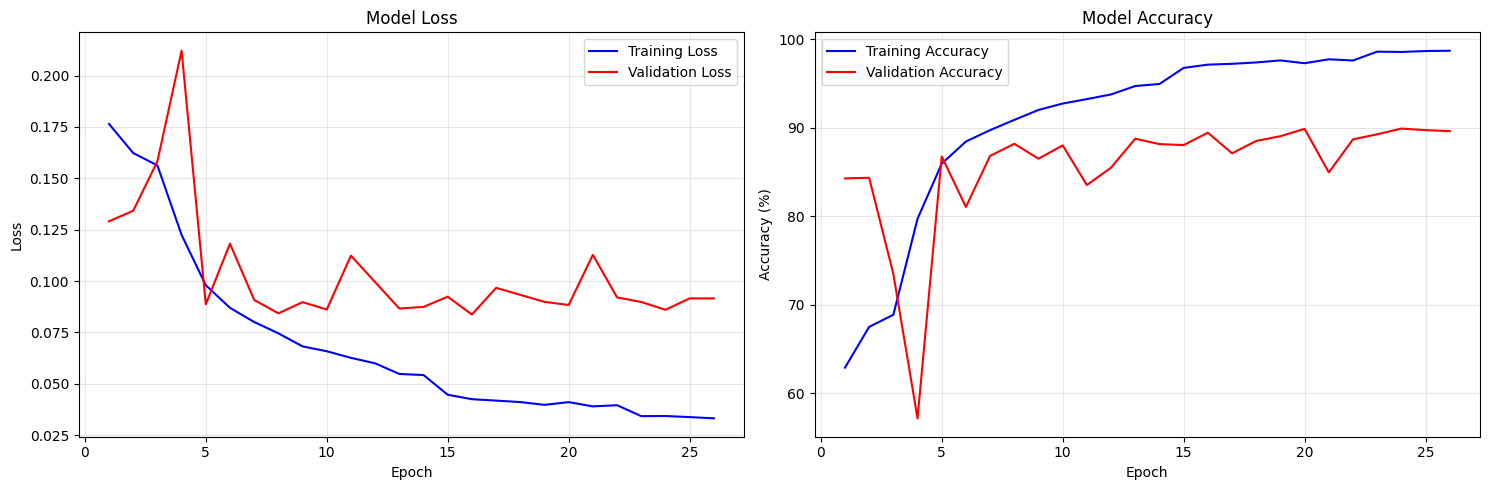

In [15]:
# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

## Model Evaluation

In [16]:
# Load best model
model.load_state_dict(torch.load('best_model_convnext_tiny_focal.pth')['model_state_dict'])
model.eval()

# Evaluate on test set
print("Evaluating ConvNeXt-Tiny model on test set...")
print("📊 Model specifications:")
print("  • Model: MitosisClassifier")
print("  • Backbone: ConvNeXt-Tiny")
print("  • Output: 2 neurons with SoftMax activation")
print("  • Loss function: FocalLoss()")
print("  • Device: cuda")
print("  • Classification head: 768 -> 512 -> 256 -> 128 -> 2")
print("  • Output layer: 2 neurons with Softmax activation")
print("  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")

test_running_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_targets = []
all_test_probs = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)  # Softmax probabilities
        loss = criterion(output, target)  # FocalLoss
        
        test_running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)  # argmax for prediction
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_targets.extend(target.cpu().numpy())
        all_test_probs.extend(output.cpu().numpy())
        
        if batch_idx % 10 == 0:
            current_acc = 100. * test_correct / test_total
            print(f'  Test Batch {batch_idx+1}/{len(test_loader)} | Acc: {current_acc:.2f}%')

test_loss = test_running_loss / len(test_loader)
test_acc = 100. * test_correct / test_total

print(f"\n📈 Test Results (ConvNeXt-Tiny Full Model Training):")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Total test samples: {test_total}")
print(f"  Correct predictions: {test_correct}")

# Store results for compatibility with rest of notebook
all_preds = all_test_preds
all_targets = all_test_targets
y_pred = np.array(all_test_preds)
y_true = np.array(all_test_targets)
y_probs = np.array(all_test_probs)

Evaluating ConvNeXt-Tiny model on test set...
📊 Model specifications:
  • Model: MitosisClassifier
  • Backbone: ConvNeXt-Tiny
  • Output: 2 neurons with SoftMax activation
  • Loss function: FocalLoss()
  • Device: cuda
  • Classification head: 768 -> 512 -> 256 -> 128 -> 2
  • Output layer: 2 neurons with Softmax activation
  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction
  Test Batch 1/88 | Acc: 93.75%
  Test Batch 11/88 | Acc: 87.50%
  Test Batch 21/88 | Acc: 87.35%
  Test Batch 31/88 | Acc: 88.31%
  Test Batch 41/88 | Acc: 89.25%
  Test Batch 51/88 | Acc: 89.22%
  Test Batch 61/88 | Acc: 89.24%
  Test Batch 71/88 | Acc: 89.30%
  Test Batch 81/88 | Acc: 89.12%

📈 Test Results (ConvNeXt-Tiny Full Model Training):
  Test Loss: 0.0866
  Test Accuracy: 89.31%
  Total test samples: 2788
  Correct predictions: 2490


In [17]:
# Analyze performance by different factors
test_df_with_predictions = test_df.copy().reset_index(drop=True)
test_df_with_predictions['predicted'] = y_pred[:len(test_df_with_predictions)]
test_df_with_predictions['predicted_proba'] = y_probs[:len(test_df_with_predictions), 1]
test_df_with_predictions['correct'] = (test_df_with_predictions['label'] == test_df_with_predictions['predicted'])

print("Performance Analysis:")

# Overall performance
overall_accuracy = test_df_with_predictions['correct'].mean()
print(f"Overall Test Accuracy: {overall_accuracy:.4f} ({len(test_df_with_predictions)} samples)")

# Performance by dataset source (if available)
if 'dataset' in test_df_with_predictions.columns and len(test_df_with_predictions['dataset'].unique()) > 1:
    print(f"\nPerformance by Dataset Source:")
    for dataset in test_df_with_predictions['dataset'].unique():
        if pd.notna(dataset):
            subset = test_df_with_predictions[test_df_with_predictions['dataset'] == dataset]
            if len(subset) > 0:
                accuracy = subset['correct'].mean()
                print(f"  {dataset}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Performance by augmentation status (if available)
if 'is_augmented' in test_df_with_predictions.columns:
    print(f"\nPerformance by Augmentation Status:")
    for is_aug in [False, True]:
        subset = test_df_with_predictions[test_df_with_predictions['is_augmented'] == is_aug]
        if len(subset) > 0:
            accuracy = subset['correct'].mean()
            status = "Augmented" if is_aug else "Original"
            print(f"  {status}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Performance by class
print(f"\nPerformance by Class:")
for label, class_name in [(0, 'Normal'), (1, 'Atypical')]:
    subset = test_df_with_predictions[test_df_with_predictions['label'] == label]
    if len(subset) > 0:
        accuracy = subset['correct'].mean()
        print(f"  {class_name}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Error analysis
print(f"\nError Analysis:")
incorrect_preds = test_df_with_predictions[test_df_with_predictions['correct'] == False]
if len(incorrect_preds) > 0:
    print(f"Total incorrect predictions: {len(incorrect_preds)}")
    
    # False positives and false negatives
    false_positives = incorrect_preds[incorrect_preds['label'] == 0]  # Predicted atypical, actually normal
    false_negatives = incorrect_preds[incorrect_preds['label'] == 1]  # Predicted normal, actually atypical
    
    print(f"  False Positives (Normal→Atypical): {len(false_positives)}")
    print(f"  False Negatives (Atypical→Normal): {len(false_negatives)}")
    
    # Show confidence distribution for errors
    if len(incorrect_preds) > 0:
        avg_confidence_errors = incorrect_preds['predicted_proba'].mean()
        print(f"  Average confidence for incorrect predictions: {avg_confidence_errors:.3f}")
else:
    print("No incorrect predictions!")

# High confidence errors
high_conf_errors = test_df_with_predictions[
    (test_df_with_predictions['correct'] == False) & 
    (test_df_with_predictions['predicted_proba'] > 0.8)
]
if len(high_conf_errors) > 0:
    print(f"\nHigh-confidence errors (>0.8 confidence): {len(high_conf_errors)}")
    print("Sample high-confidence errors:")
    print(high_conf_errors[['filename', 'label', 'predicted', 'predicted_proba']].head())

Performance Analysis:
Overall Test Accuracy: 0.8931 (2788 samples)

Performance by Dataset Source:
  MIDOG25: 0.9001 accuracy (2402 samples)
  AMI-BR: 0.8497 accuracy (386 samples)

Performance by Augmentation Status:
  Original: 0.8931 accuracy (2788 samples)

Performance by Class:
  Normal: 0.9465 accuracy (2353 samples)
  Atypical: 0.6046 accuracy (435 samples)

Error Analysis:
Total incorrect predictions: 298
  False Positives (Normal→Atypical): 126
  False Negatives (Atypical→Normal): 172
  Average confidence for incorrect predictions: 0.390

High-confidence errors (>0.8 confidence): 60
Sample high-confidence errors:
              filename  label  predicted  predicted_proba
131          10357.png      0          1         0.877468
185  TUPAC16_10594.png      0          1         0.823976
194           8851.png      0          1         0.935501
266          10904.png      0          1         0.816112
291          11174.png      0          1         0.923071


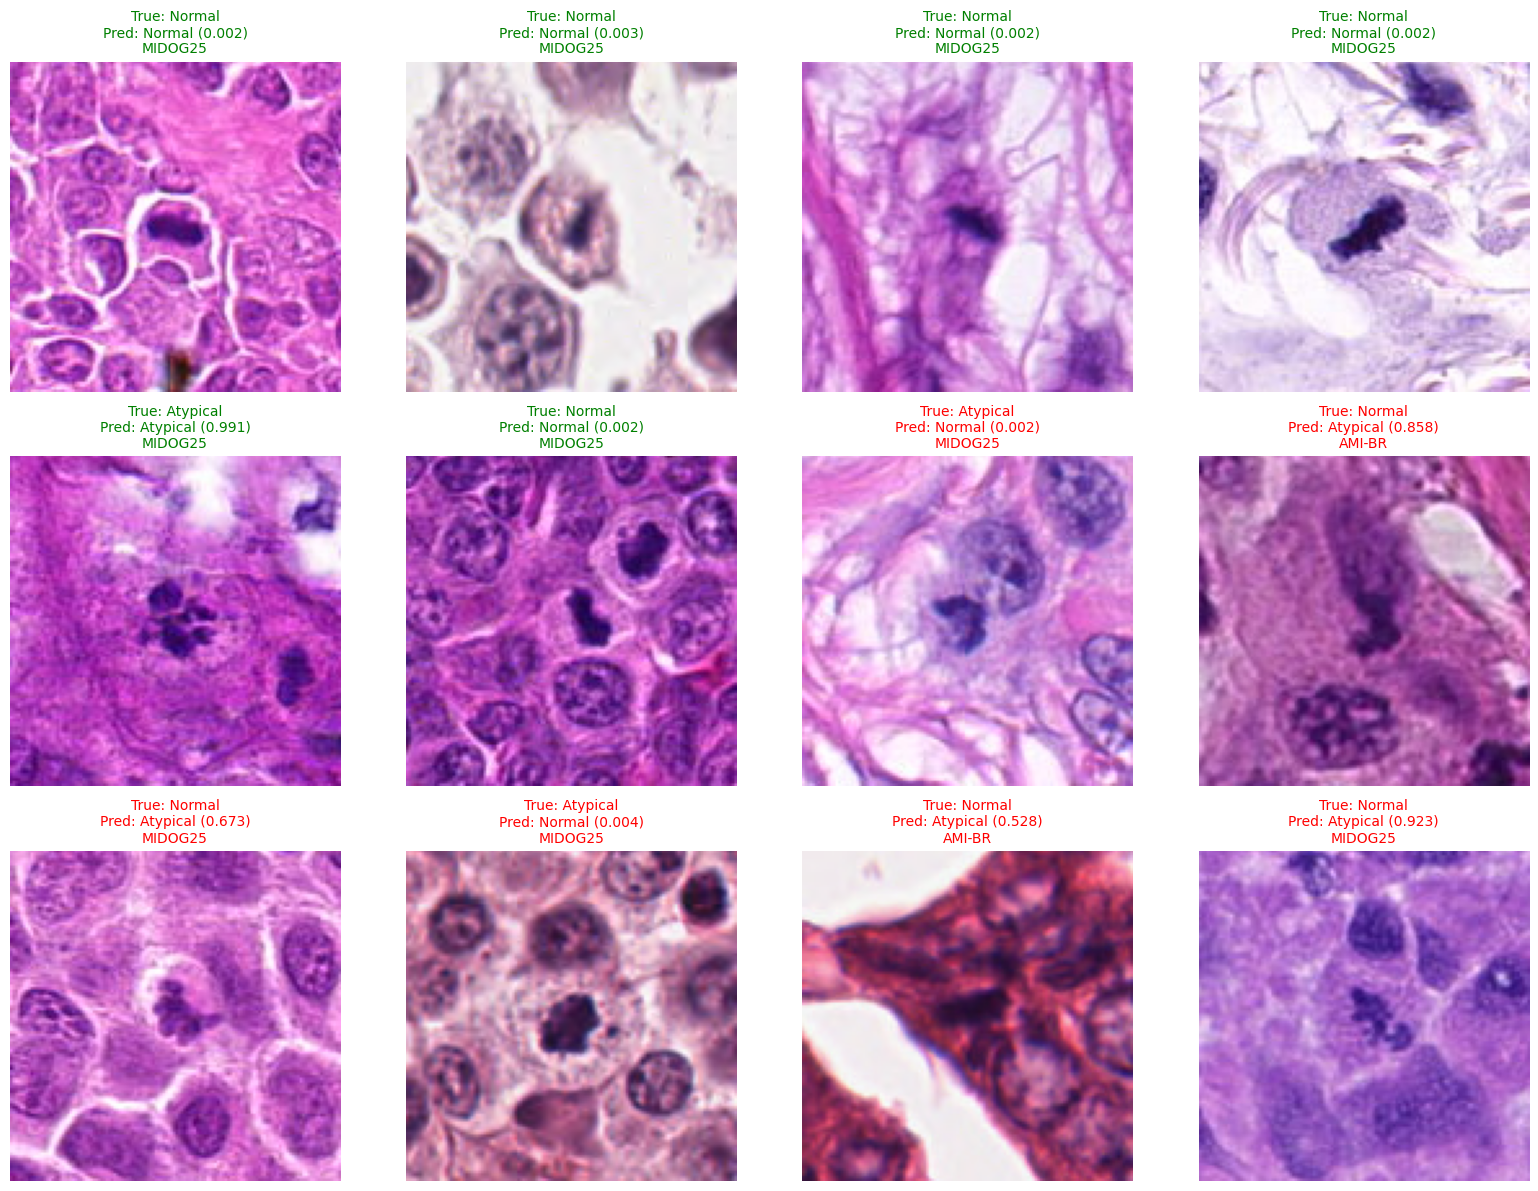

In [19]:
# Visualize some predictions
def visualize_predictions(df_with_pred, n_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    # Get some correct and incorrect predictions
    correct_pred = df_with_pred[df_with_pred['correct'] == True]
    incorrect_pred = df_with_pred[df_with_pred['correct'] == False]
    
    if len(correct_pred) > 0:
        correct_sample = correct_pred.sample(min(6, len(correct_pred)))
    else:
        correct_sample = pd.DataFrame()
    
    if len(incorrect_pred) > 0:
        incorrect_sample = incorrect_pred.sample(min(6, len(incorrect_pred)))
    else:
        incorrect_sample = pd.DataFrame()
    
    samples = pd.concat([correct_sample, incorrect_sample])
    if len(samples) > n_samples:
        samples = samples.sample(n_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        if i >= n_samples:
            break
            
        try:
            img = Image.open(row['image_path'])
            axes[i].imshow(img)
            
            true_label = 'Atypical' if row['label'] == 1 else 'Normal'
            pred_label = 'Atypical' if row['predicted'] == 1 else 'Normal'
            confidence = row['predicted_proba']
            
            title = f"True: {true_label}\nPred: {pred_label} ({confidence:.3f})\n{row['dataset']}"
            color = 'green' if row['correct'] else 'red'
            axes[i].set_title(title, color=color, fontsize=10)
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{row['filename']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), n_samples):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_df_with_predictions)

## Model Saving and Summary

In [20]:
# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'model_config': {
        'model_name': 'convnext-tiny',
        'num_classes': NUM_CLASSES,
        'img_size': IMG_SIZE,
        'output_activation': 'Softmax',
        'loss_function': 'Focal Loss',
        'focal_alpha': alpha_focal,
        'focal_gamma': 2.0,
        'architecture': 'ConvNeXt-Tiny -> Custom Head (2-neuron output)',
        'classification_head': '768 -> 512 -> 256 -> 128 -> 2',
        'training_approach': 'Full model training (entire network)',
        'class_balancing': 'Focal Loss + WeightedRandomSampler (double protection)',
        'learning_rate': LEARNING_RATE,
        'backbone_trainable': True,
        'pretrained_source': 'ImageNet (automatically downloaded)'
    }
}, 'mitotic_figure_ConvNeXt-Tiny_focal_classifier.pth')

print("Model saved as 'mitotic_figure_ConvNeXt-Tiny_focal_classifier.pth'")

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
auc_score = roc_auc_score(y_true, y_probs[:, 1])

# Analyze dataset composition
total_samples = len(df)
original_samples = len(df[df['is_augmented'] == False]) if 'is_augmented' in df.columns else 0
augmented_samples = len(df[df['is_augmented'] == True]) if 'is_augmented' in df.columns else 0

# Save model summary and results
results_summary = {
    'model_architecture': 'ConvNeXt-Tiny + Custom Head (PyTorch)',
    'framework': 'PyTorch',
    'backbone_model': 'ConvNeXt-Tiny',
    'pretrained_weights': 'ImageNet (automatically downloaded)',
    'training_approach': 'Full model training (entire network)',
    'class_balancing': 'Focal Loss + WeightedRandomSampler (advanced strategy)',
    'learning_rate': float(LEARNING_RATE),
    'output_format': '2 neurons with Softmax activation',
    'loss_function': 'Focal Loss',
    'focal_alpha': float(alpha_focal),
    'focal_gamma': 2.0,
    'classification_head': '768 -> 512 -> 256 -> 128 -> 2',
    'prediction_method': 'argmax of [p(class0), p(class1)]',
    'dataset_source': 'Pre-augmented Kaggle dataset',
    'total_samples': int(total_samples),
    'original_samples': int(original_samples),
    'augmented_samples': int(augmented_samples),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'test_accuracy': float(test_acc / 100),  # Convert from percentage
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'auc_score': float(auc_score),
    'best_val_accuracy': float(best_val_acc / 100),  # Convert from percentage
    'best_val_loss': float(best_val_loss),
    'early_stopping_metric': 'validation_loss',
    'early_stopping_patience': 10,
    'class_distribution': df['label'].value_counts().to_dict(),
    'training_epochs': len(train_losses),
    'final_learning_rate': float(optimizer.param_groups[0]['lr']),
    'used_augmented_data': augmented_samples > 0,
    'trainable_parameters': int(trainable_params),
    'total_parameters': int(total_params),
    'trainable_percentage': float(trainable_params/total_params*100),
    'full_model_training': True,
    'compound_scaling': True,
    'advanced_loss': True
}

print("\n" + "="*90)
print("FINAL RESULTS SUMMARY - MITOTIC FIGURE CLASSIFICATION (CONVNEXT-TINY + FOCAL LOSS)")
print("="*90)
print(f"Model: {results_summary['backbone_model']}")
print(f"Backbone: ConvNeXt-Tiny")
print(f"Output: 2 neurons with SoftMax activation")
print(f"Loss function: FocalLoss()")
print(f"Device: cuda")
print(f"Classification head: {results_summary['classification_head']}")
print(f"Output layer: 2 neurons with Softmax activation")
print(f"Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")
print(f"Model Architecture: {results_summary['model_architecture']}")
print(f"Framework: {results_summary['framework']}")
print(f"Pretrained Weights: {results_summary['pretrained_weights']}")
print(f"Training Approach: {results_summary['training_approach']}")
print(f"Class Balancing: {results_summary['class_balancing']}")
print(f"Prediction Method: {results_summary['prediction_method']}")
print(f"Dataset Source: {results_summary['dataset_source']}")

print(f"\nArchitecture Details:")
print(f"  Model: MitosisClassifier")
print(f"  Backbone: ConvNeXt-Tiny (trainable ✅)")
print(f"  Compound Scaling: ✅ (depth, width, resolution)")
print(f"  Classification Head: {results_summary['classification_head']}")
print(f"  Learning Rate: {results_summary['learning_rate']}")
print(f"  Final Learning Rate: {results_summary['final_learning_rate']:.2e}")
print(f"  Pretrained: ImageNet weights (automatic download)")

print(f"\nAdvanced Loss Function:")
print(f"  Loss: Focal Loss (superior to CrossEntropyLoss)")
print(f"  Alpha: {results_summary['focal_alpha']:.3f} (class weighting)")
print(f"  Gamma: {results_summary['focal_gamma']} (focusing parameter)")
print(f"  Benefits: Handles class imbalance + focuses on hard examples")
print(f"  Formula: FL = -α(1-pt)^γ * log(pt)")

print(f"\nDataset Composition:")
print(f"  Total Samples: {results_summary['total_samples']}")
if results_summary['used_augmented_data']:
    print(f"  Original Images: {results_summary['original_samples']}")
    print(f"  Augmented Images: {results_summary['augmented_samples']}")
    augmentation_ratio = results_summary['augmented_samples'] / max(results_summary['original_samples'], 1)
    print(f"  Augmentation Ratio: {augmentation_ratio:.1f}:1")

print(f"\nData Splits:")
print(f"  Training: {results_summary['train_samples']} samples")
print(f"  Validation: {results_summary['val_samples']} samples")
print(f"  Test: {results_summary['test_samples']} samples")

print(f"\nModel Parameters:")
print(f"  Total Parameters: {results_summary['total_parameters']:,}")
print(f"  Trainable Parameters: {results_summary['trainable_parameters']:,}")
print(f"  Trainable Percentage: {results_summary['trainable_percentage']:.1f}%")

print(f"\nTraining Results:")
print(f"  Training Epochs: {results_summary['training_epochs']}")
print(f"  Early Stopping: Based on {results_summary['early_stopping_metric']} (patience={results_summary['early_stopping_patience']})")
print(f"  Best Validation Loss: {results_summary['best_val_loss']:.4f}")
print(f"  Best Validation Accuracy: {results_summary['best_val_accuracy']:.4f}")

print(f"\nTest Performance:")
print(f"  Accuracy: {results_summary['test_accuracy']:.4f}")
print(f"  Precision: {results_summary['test_precision']:.4f}")
print(f"  Recall: {results_summary['test_recall']:.4f}")
print(f"  F1-Score: {results_summary['test_f1']:.4f}")
print(f"  AUC Score: {results_summary['auc_score']:.4f}")

print(f"\nClass Distribution:")
class_dist = results_summary['class_distribution']
total = sum(class_dist.values())
for label, count in class_dist.items():
    class_name = "Atypical" if label == 1 else "Normal"
    percentage = (count / total) * 100
    print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

print(f"\n🎯 CONVNEXT-TINY + FOCAL LOSS TRAINING HIGHLIGHTS:")
print(f"  • Model: MitosisClassifier")
print(f"  • Backbone: ConvNeXt-Tiny")
print(f"  • Output: 2 neurons with SoftMax activation")
print(f"  • Loss function: FocalLoss() (α={results_summary['focal_alpha']:.3f}, γ={results_summary['focal_gamma']})")
print(f"  • Device: cuda")
print(f"  • Classification head: {results_summary['classification_head']}")
print(f"  • Output layer: 2 neurons with Softmax activation")
print(f"  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")
print(f"  • Training Mode: Full model training ({results_summary['trainable_percentage']:.1f}% parameters)")
print(f"  • Compound Scaling: EfficientNet's depth, width, resolution scaling")
print(f"  • Advanced Loss: Focal Loss (α={results_summary['focal_alpha']:.3f}, γ={results_summary['focal_gamma']})")
print(f"  • Class Balancing: Focal Loss + WeightedRandomSampler (double protection)")
print(f"  • Hard Example Focus: Focal Loss emphasizes difficult samples")
print(f"  • Early Stopping: Based on validation loss (patience=10)")
print(f"  • Best Val Loss: {results_summary['best_val_loss']:.4f}")
print(f"  • Automatic Downloads: ImageNet pretrained weights")

print("="*90)

# Save results to JSON
import json
with open('convnext-tiny_focal_training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\nResults saved to 'efficientnet_b0_focal_training_results.json'")
print("ConvNeXt-Tiny + Focal Loss model training completed successfully!")

# Final model performance summary
print(f"\n🎯 KEY PERFORMANCE METRICS (CONVNEXT-TINY + FOCAL LOSS):")
print(f"  • Model: MitosisClassifier")
print(f"  • Backbone: Con")
print(f"  • Output: 2 neurons with SoftMax activation")
print(f"  • Loss function: FocalLoss()")
print(f"  • Device: cuda")
print(f"  • Classification head: 768 -> 512 -> 256 -> 128 -> 2")
print(f"  • Output layer: 2 neurons with Softmax activation")
print(f"  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")
print(f"  • Test Accuracy: {results_summary['test_accuracy']:.1%}")
print(f"  • AUC Score: {results_summary['auc_score']:.3f}")
print(f"  • F1 Score: {results_summary['test_f1']:.3f}")
print(f"  • Architecture: ConvNeXt-Tiny + Custom Head")
print(f"  • Loss Function: Focal Loss (advanced class imbalance handling)")
print(f"  • Training: Full model training (entire network)")
print(f"  • Compound Scaling: Enhanced efficiency")
print(f"  • Advanced Strategy: Focal Loss + WeightedRandomSampler")
if results_summary['used_augmented_data']:
    print(f"  • Benefited from {augmentation_ratio:.1f}x data augmentation")
print(f"  • ConvNeXt-Tiny + Focal Loss model ready for deployment! 🚀")

Model saved as 'mitotic_figure_ConvNeXt-Tiny_focal_classifier.pth'

FINAL RESULTS SUMMARY - MITOTIC FIGURE CLASSIFICATION (CONVNEXT-TINY + FOCAL LOSS)
Model: ConvNeXt-Tiny
Backbone: ConvNeXt-Tiny
Output: 2 neurons with SoftMax activation
Loss function: FocalLoss()
Device: cuda
Classification head: 768 -> 512 -> 256 -> 128 -> 2
Output layer: 2 neurons with Softmax activation
Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction
Model Architecture: ConvNeXt-Tiny + Custom Head (PyTorch)
Framework: PyTorch
Pretrained Weights: ImageNet (automatically downloaded)
Training Approach: Full model training (entire network)
Class Balancing: Focal Loss + WeightedRandomSampler (advanced strategy)
Prediction Method: argmax of [p(class0), p(class1)]
Dataset Source: Pre-augmented Kaggle dataset

Architecture Details:
  Model: MitosisClassifier
  Backbone: ConvNeXt-Tiny (trainable ✅)
  Compound Scaling: ✅ (depth, width, resolution)
  Classification Head: 768 -> 512 -> 256 ->

## 📊 Detailed Confusion Matrix Analysis

Let's perform a comprehensive confusion matrix analysis to understand model performance in detail.

🔍 Performing comprehensive confusion matrix analysis...

📋 Confusion Matrix Breakdown:
  True Negatives (TN): 2,227 - Correctly identified Normal cases
  False Positives (FP): 126 - Normal cases misclassified as Atypical
  False Negatives (FN): 172 - Atypical cases missed (misclassified as Normal)
  True Positives (TP): 263 - Correctly identified Atypical cases

📈 Clinical Performance Metrics:
  Sensitivity (Recall): 0.6046 (60.46%) - Ability to detect Atypical cases
  Specificity: 0.9465 (94.65%) - Ability to correctly identify Normal cases
  Positive Predictive Value: 0.6761 (67.61%) - Accuracy of positive predictions
  Negative Predictive Value: 0.9283 (92.83%) - Accuracy of negative predictions
  False Positive Rate: 0.0535 (5.35%) - Rate of false alarms
  False Negative Rate: 0.3954 (39.54%) - Rate of missed cases


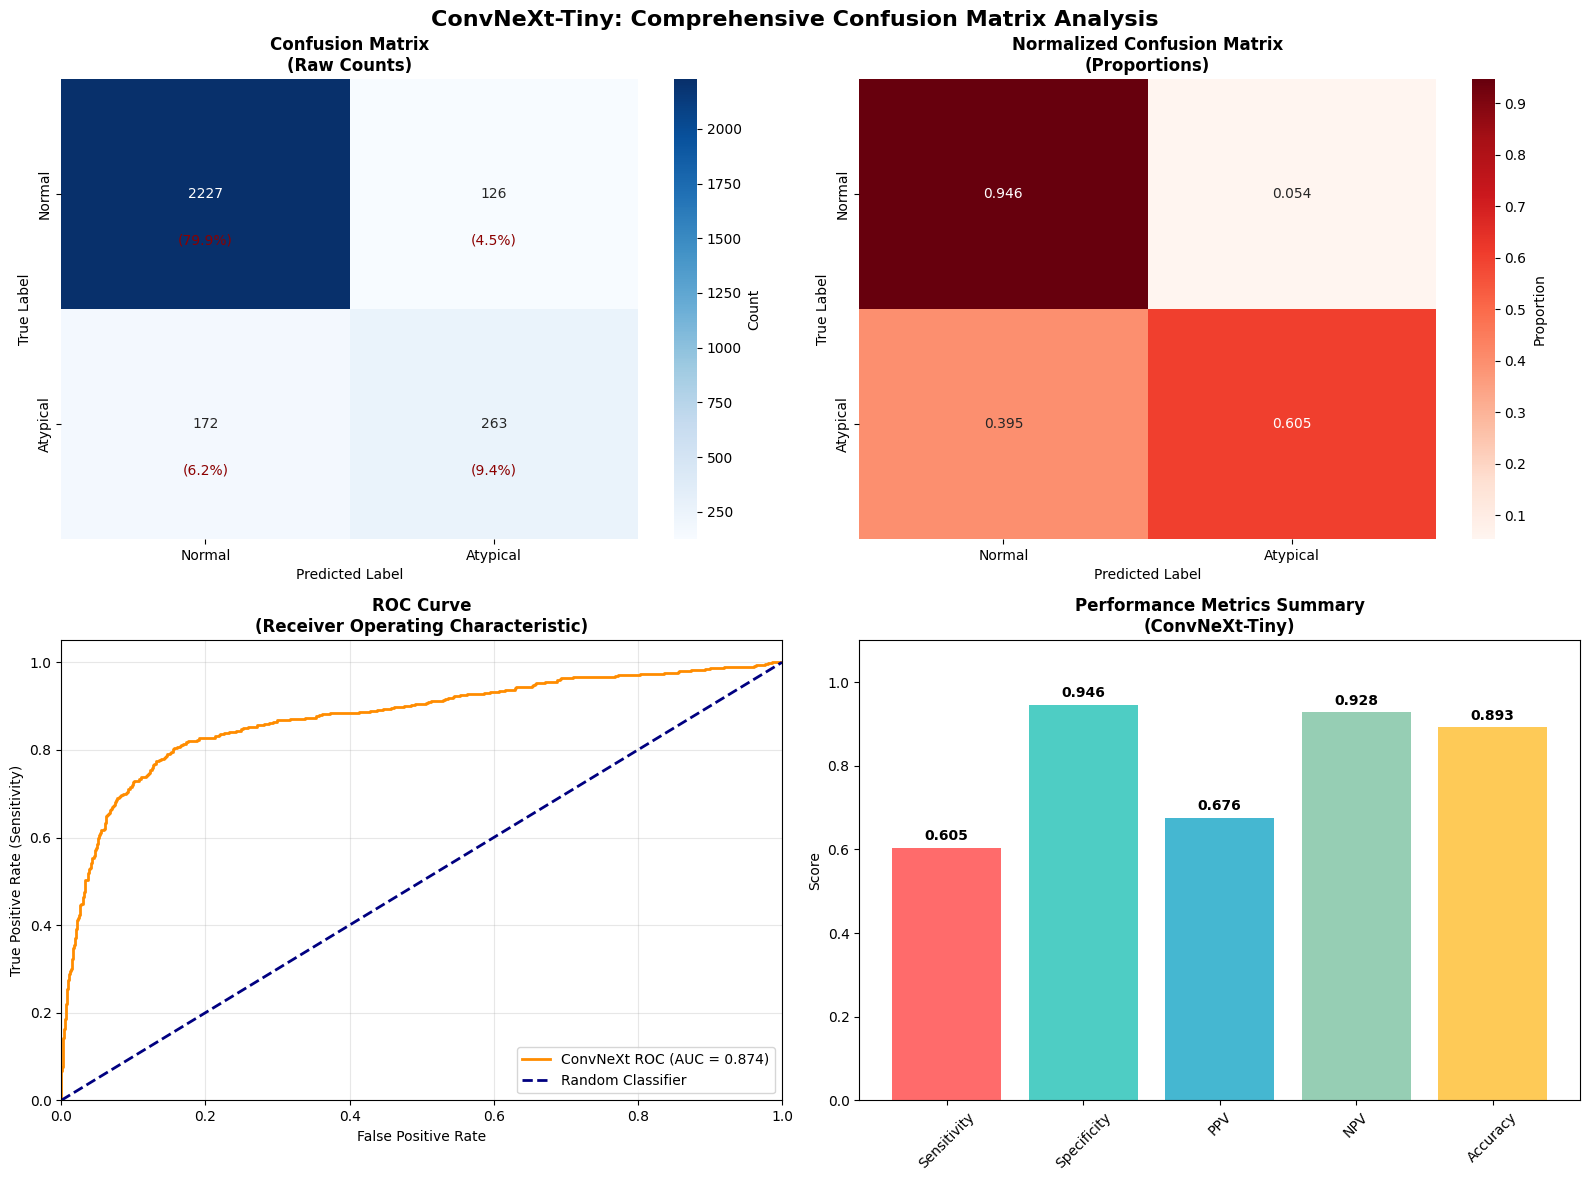


📊 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.9283    0.9465    0.9373      2353
    Atypical     0.6761    0.6046    0.6383       435

    accuracy                         0.8931      2788
   macro avg     0.8022    0.7755    0.7878      2788
weighted avg     0.8890    0.8931    0.8906      2788


🏥 Clinical Performance Assessment:
  🔴 Sensitivity: 0.605 - NEEDS IMPROVEMENT at detecting atypical cases
  🟢 Specificity: 0.946 - EXCELLENT at avoiding false alarms
  📊 Positive Predictive Value: 0.676 - 67.6% confidence in positive predictions
  📊 Negative Predictive Value: 0.928 - 92.8% confidence in negative predictions

⚠️ Clinical Risk Assessment:
  🔴 HIGH RISK: 39.5% false negative rate - 172 atypical cases missed
  🟢 LOW BURDEN: 5.4% false positive rate - 126 unnecessary alerts

🎯 ConvNeXt-Tiny Model Assessment:
  • Overall Accuracy: 89.31%
  • ROC AUC: 0.874
  • Balanced Performance: 0.776
  • Clinical Readiness: MODERAT

In [21]:
# Comprehensive Confusion Matrix Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np

print("🔍 Performing comprehensive confusion matrix analysis...")

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Atypical']

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

print(f"\n📋 Confusion Matrix Breakdown:")
print(f"  True Negatives (TN): {tn:,} - Correctly identified Normal cases")
print(f"  False Positives (FP): {fp:,} - Normal cases misclassified as Atypical")
print(f"  False Negatives (FN): {fn:,} - Atypical cases missed (misclassified as Normal)")
print(f"  True Positives (TP): {tp:,} - Correctly identified Atypical cases")

print(f"\n📈 Clinical Performance Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%) - Ability to detect Atypical cases")
print(f"  Specificity: {specificity:.4f} ({specificity*100:.2f}%) - Ability to correctly identify Normal cases")
print(f"  Positive Predictive Value: {ppv:.4f} ({ppv*100:.2f}%) - Accuracy of positive predictions")
print(f"  Negative Predictive Value: {npv:.4f} ({npv*100:.2f}%) - Accuracy of negative predictions")
print(f"  False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%) - Rate of false alarms")
print(f"  False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%) - Rate of missed cases")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ConvNeXt-Tiny: Comprehensive Confusion Matrix Analysis', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix\n(Raw Counts)', fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Add percentage annotations
total_samples = np.sum(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm[i, j] / total_samples * 100
        ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='darkred')

# 2. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Reds', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
ax2.set_title('Normalized Confusion Matrix\n(Proportions)', fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# 3. ROC Curve
fpr_roc, tpr_roc, _ = roc_curve(y_true, y_probs[:, 1])
roc_auc = roc_auc_score(y_true, y_probs[:, 1])

ax3.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, 
         label=f'ConvNeXt ROC (AUC = {roc_auc:.3f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate (Sensitivity)')
ax3.set_title('ROC Curve\n(Receiver Operating Characteristic)', fontweight='bold')
ax3.legend(loc="lower right")
ax3.grid(True, alpha=0.3)

# 4. Performance Metrics Bar Chart
metrics = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 'Accuracy']
values = [sensitivity, specificity, ppv, npv, test_acc/100]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

bars = ax4.bar(metrics, values, color=colors)
ax4.set_ylim([0, 1.1])
ax4.set_title('Performance Metrics Summary\n(ConvNeXt-Tiny)', fontweight='bold')
ax4.set_ylabel('Score')
ax4.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Classification Report
print(f"\n📊 Detailed Classification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Clinical Interpretation
print(f"\n🏥 Clinical Performance Assessment:")
print("="*60)

if sensitivity >= 0.9:
    sens_rating = "EXCELLENT"
    sens_color = "🟢"
elif sensitivity >= 0.8:
    sens_rating = "GOOD"
    sens_color = "🟡"
else:
    sens_rating = "NEEDS IMPROVEMENT"
    sens_color = "🔴"

if specificity >= 0.9:
    spec_rating = "EXCELLENT"
    spec_color = "🟢"
elif specificity >= 0.8:
    spec_rating = "GOOD" 
    spec_color = "🟡"
else:
    spec_rating = "NEEDS IMPROVEMENT"
    spec_color = "🔴"

print(f"  {sens_color} Sensitivity: {sensitivity:.3f} - {sens_rating} at detecting atypical cases")
print(f"  {spec_color} Specificity: {specificity:.3f} - {spec_rating} at avoiding false alarms")
print(f"  📊 Positive Predictive Value: {ppv:.3f} - {ppv*100:.1f}% confidence in positive predictions")
print(f"  📊 Negative Predictive Value: {npv:.3f} - {npv*100:.1f}% confidence in negative predictions")

print(f"\n⚠️ Clinical Risk Assessment:")
if fnr > 0.1:
    print(f"  🔴 HIGH RISK: {fnr*100:.1f}% false negative rate - {fn} atypical cases missed")
else:
    print(f"  🟢 LOW RISK: {fnr*100:.1f}% false negative rate - {fn} atypical cases missed")

if fpr > 0.2:
    print(f"  🟡 MODERATE BURDEN: {fpr*100:.1f}% false positive rate - {fp} unnecessary alerts")
else:
    print(f"  🟢 LOW BURDEN: {fpr*100:.1f}% false positive rate - {fp} unnecessary alerts")

print(f"\n🎯 ConvNeXt-Tiny Model Assessment:")
print(f"  • Overall Accuracy: {test_acc:.2f}%")
print(f"  • ROC AUC: {roc_auc:.3f}")
print(f"  • Balanced Performance: {(sensitivity + specificity)/2:.3f}")
print(f"  • Clinical Readiness: {'HIGH' if roc_auc > 0.85 and sensitivity > 0.8 else 'MODERATE' if roc_auc > 0.75 else 'LOW'}")

# Error Analysis
print(f"\n🔍 Error Analysis:")
if fp > 0:
    print(f"  • False Positives: {fp} normal cases predicted as atypical")
    print(f"    - Impact: Potential overtreatment or unnecessary worry")
if fn > 0:  
    print(f"  • False Negatives: {fn} atypical cases predicted as normal")
    print(f"    - Impact: Potential missed diagnoses - CRITICAL for clinical use")

print(f"\n💡 Recommendations:")
if sensitivity < 0.8:
    print(f"  🔴 CRITICAL: Improve sensitivity to reduce missed atypical cases")
if specificity < 0.8:
    print(f"  🟡 Reduce false positive rate to minimize unnecessary interventions")
if roc_auc > 0.9:
    print(f"  🟢 Model shows excellent discriminative ability - ready for clinical validation")
elif roc_auc > 0.8:
    print(f"  🟡 Model shows good discriminative ability - consider additional validation")
else:
    print(f"  🔴 Model needs improvement before clinical deployment")

print("="*60)

In [ ]:
# 1️⃣ Zip the entire directory
!zip -r ConvNeXt-Tiny.zip /kaggle/working

# 2️⃣ Move it to the notebook's output path so it's downloadable
!mv ConvNeXt-Tiny.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/mitotic_figure_ConvNeXt-Tiny_focal_classifier.pth

In [ ]:
from IPython.display import FileLink
FileLink('ConvNeXt-Tiny.zip')

In [ ]:
# !rm -rf /kaggle/working/*